# EDA_vuelos.ipynb


Se realiza un EDA completo usando los archivos: `sample_100000.csv`, `dim_airline.csv`, `dim_airport.csv`, `dim_date.csv`.

Este notebook incluye:
- Carga y validación de datos con dtypes robustos
- Limpieza y enriquecimiento (joins con dimensiones)
- Análisis descriptivo y visualizaciones obligatorias
- Respuestas de negocio, conclusiones y recomendaciones

----


## 1) Librerías y configuración inicial

Se importan librerías comunes y se fija estilo para reproducibilidad visual.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mtick
import sys

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


### Versión de librerías (reproducibilidad)


In [ ]:
print('python:', sys.version.splitlines()[0])
import matplotlib
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pandas 2.2.2
numpy 2.0.2
matplotlib 3.10.0
seaborn 0.13.2


## 2) Rutas de archivos

Ajusta las rutas si trabajas en Colab (sube archivos) o si usas un bucket/drive.

In [ ]:
# Rutas de archivos (ajusta si es necesario)
FACT_PATH = "sample_100000.csv"
AIRLINE_PATH = "dim_airline.csv"
AIRPORT_PATH = "dim_airport.csv"
DATE_PATH = "dim_date.csv"

print('Asegúrate de que los archivos están en el mismo directorio o actualiza las rutas.')


Asegúrate de que los archivos están en el mismo directorio o actualiza las rutas.


## 3) Carga y validación de datos


In [ ]:
# Lectura inicial con low_memory para evitar warnings
fact = pd.read_csv(FACT_PATH, low_memory=False)
airlines = pd.read_csv(AIRLINE_PATH)
airports = pd.read_csv(AIRPORT_PATH)
dates = pd.read_csv(DATE_PATH, low_memory=False)

print("fact shape:", fact.shape)
print("airlines shape:", airlines.shape)
print("airports shape:", airports.shape)
print("dates shape:", dates.shape)

# Mostrar muestras
display(fact.head())
display(airlines.head())
display(airports.head())
display(dates.head())


fact shape: (100000, 10)
airlines shape: (23, 3)
airports shape: (385, 5)
dates shape: (4017, 8)


,fact_id,airline_id,origin_airport_id,destination_airport_id,fecha_id,dep_delay,arr_delay,total_delay,distance,flight_status
0,43156559,19,69,235,3815,84,81.0,165.0,489,Completed
1,43222868,10,77,55,3064,122,128.0,250.0,675,Completed
2,35243875,21,339,281,868,19,23.0,42.0,647,Completed
3,39582251,10,208,264,1664,31,21.0,52.0,324,Completed
4,41025415,12,328,46,3121,33,22.0,55.0,522,Completed


,airline_id,carrier_code,airline_name
0,1,VX,Virgin America
1,2,OH,PSA Airlines
2,3,WN,Southwest Airlines
3,4,DL,Delta Air Lines
4,5,XE,ExpressJet Airlines


,airport_id,airport_code,airport_name,city,state
1,ABE,NaN,Allentown/Bethlehem/Easton,PA,PA
2,ABI,NaN,Abilene,TX,TX
3,ABQ,NaN,Albuquerque,NM,NM
4,ABR,NaN,Aberdeen,SD,SD
5,ABY,NaN,Albany,GA,GA


,fecha_id,fecha,year,month,day,quarter,weekday,is_holiday
0,1,2009-01-01,2009,1,1,1,5,False
1,2,2009-01-02,2009,1,2,1,6,False
2,3,2009-01-03,2009,1,3,1,7,False
3,4,2009-01-04,2009,1,4,1,1,False
4,5,2009-01-05,2009,1,5,1,2,False


In [ ]:
print('\n--- info fact ---')
fact.info()
print('\n--- describe fact ---')
display(fact.describe(include='all').T)
print('\n--- nulos fact ---')
display(fact.isnull().sum().sort_values(ascending=False).head(40))



--- info fact ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   fact_id                 100000 non-null  int64  
 1   airline_id              100000 non-null  int64  
 2   origin_airport_id       100000 non-null  int64  
 3   destination_airport_id  100000 non-null  int64  
 4   fecha_id                100000 non-null  int64  
 5   dep_delay               100000 non-null  int64  
 6   arr_delay               99394 non-null   float64
 7   total_delay             99394 non-null   float64
 8   distance                100000 non-null  int64  
 9   flight_status           100000 non-null  object 
dtypes: float64(2), int64(7), object(1)
memory usage: 7.6+ MB

--- describe fact ---


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fact_id,100000.0,NaN,NaN,NaN,39850535.90582,3566759.344311,33679348.0,36760864.5,39854433.0,42931379.75,46036291.0
airline_id,100000.0,NaN,NaN,NaN,11.40862,7.621033,1.0,3.0,10.0,20.0,23.0
origin_airport_id,100000.0,NaN,NaN,NaN,184.46251,101.828956,1.0,97.0,199.0,264.0,384.0
destination_airport_id,100000.0,NaN,NaN,NaN,188.74303,103.088744,1.0,97.0,201.0,274.0,384.0
fecha_id,100000.0,NaN,NaN,NaN,2058.74278,1179.956406,1.0,1018.0,2024.0,3118.0,4017.0
dep_delay,100000.0,NaN,NaN,NaN,60.95699,71.084959,15.0,23.0,38.0,72.0,1487.0
arr_delay,99394.0,NaN,NaN,NaN,57.162334,72.820331,0.0,18.0,36.0,71.0,1478.0
total_delay,99394.0,NaN,NaN,NaN,117.914039,142.606939,15.0,42.0,74.0,142.0,2962.0
distance,100000.0,NaN,NaN,NaN,805.80614,588.102977,31.0,369.0,646.0,1045.0,4983.0
flight_status,100000,3,Completed,99394,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- nulos fact ---


,0
arr_delay,606
total_delay,606
airline_id,0
fact_id,0
origin_airport_id,0
destination_airport_id,0
dep_delay,0
fecha_id,0
distance,0
flight_status,0


## 4) Limpieza y enriquecimiento



In [ ]:
# Normalizar nombres de columnas
fact.columns = [c.strip() for c in fact.columns]
airlines.columns = [c.strip() for c in airlines.columns]
airports.columns = [c.strip() for c in airports.columns]
dates.columns = [c.strip() for c in dates.columns]

# Mapear nombres de columnas esperadas según tu diccionario (ajusta si tus columnas tienen otros nombres)
aliases = {
    "airline_id":"airline_id",
    "origin_airport_id":"origin_airport_id",
    "destination_airport_id":"destination_airport_id",
    "DepDelayMinutes":"DepDelayMinutes",
    "ArrDelayMinutes":"ArrDelayMinutes",
    "DepDel15":"DepDel15",
    "Distance":"Distance",
    "FlightDate":"FlightDate",
    "fecha_id":"fecha_id"
}

# Convertir FlightDate si existe
if "FlightDate" in fact.columns:
    fact["FlightDate"] = pd.to_datetime(fact["FlightDate"], errors="coerce")

# Convertir fecha en dim_date si aplica
if "fecha" in dates.columns:
    dates["fecha"] = pd.to_datetime(dates["fecha"], errors="coerce")

# Imputaciones según Diccionario_Final
delay_cause_cols = ["CarrierDelay","WeatherDelay","NASDelay","SecurityDelay","LateAircraftDelay"]
for c in delay_cause_cols:
    if c in fact.columns:
        fact[c] = fact[c].fillna(0).astype("Int64")

# Cancelled y Diverted
if "Cancelled" in fact.columns:
    fact["Cancelled"] = fact["Cancelled"].fillna(0).astype(int)
if "Diverted" in fact.columns:
    fact["Diverted"] = fact["Diverted"].fillna(0).astype(int)

# Crear flight_status
def _status(r):
    if r.get("Cancelled", 0) == 1:
        return "Cancelled"
    if r.get("Diverted", 0) == 1:
        return "Diverted"
    return "Normal"

fact["flight_status"] = fact.apply(_status, axis=1)

# Normalizar tipos para joins con aeropuertos
if "origin_airport_id" in fact.columns:
    fact["origin_airport_id"] = fact["origin_airport_id"].astype(str)

if "destination_airport_id" in fact.columns:
    fact["destination_airport_id"] = fact["destination_airport_id"].astype(str)

if "airport_id" in airports.columns:
    airports["airport_id"] = airports["airport_id"].astype(str)

# ============================
# JOINS CON DIMENSIONES
# ============================

# Aerolínea
if "airline_id" in fact.columns and "airline_id" in airlines.columns:
    fact = fact.merge(airlines, on="airline_id", how="left")

# Aeropuerto origen
if "origin_airport_id" in fact.columns and "airport_id" in airports.columns:

    ap_o = airports.rename(columns={
        "airport_id": "origin_airport_id",
        "airport_code": "origin_code",
        "airport_name": "origin_name",
        "city": "origin_city",
        "state": "origin_state"
    })

    fact = fact.merge(
        ap_o[["origin_airport_id", "origin_code", "origin_name", "origin_city", "origin_state"]],
        on="origin_airport_id",
        how="left"
    )

# Aeropuerto destino
if "destination_airport_id" in fact.columns and "airport_id" in airports.columns:

    ap_d = airports.rename(columns={
        "airport_id": "destination_airport_id",
        "airport_code": "dest_code",
        "airport_name": "dest_name",
        "city": "dest_city",
        "state": "dest_state"
    })

    fact = fact.merge(
        ap_d[["destination_airport_id", "dest_code", "dest_name", "dest_city", "dest_state"]],
        on="destination_airport_id",
        how="left"
    )

# Fecha por fecha_id
if "fecha_id" in fact.columns and "fecha_id" in dates.columns:
    fact = fact.merge(dates, on="fecha_id", how="left")

print("After merges shape:", fact.shape)
display(fact.head())



After merges shape: (100000, 31)


,fact_id,airline_id,origin_airport_id,destination_airport_id,fecha_id,dep_delay,arr_delay,total_delay,distance,flight_status,carrier_code_x,airline_name_x,carrier_code_y,airline_name_y,carrier_code,airline_name,origin_code,origin_name,origin_city,origin_state,dest_code,dest_name,dest_city,dest_state,fecha,year,month,day,quarter,weekday,is_holiday
0,43156559,19,69,235,3815,84,81.0,165.0,489,Normal,YX,Midwest Airlines,YX,Midwest Airlines,YX,Midwest Airlines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-12,2019,6,12,2,4,False
1,43222868,10,77,55,3064,122,128.0,250.0,675,Normal,EV,Atlantic Southeast Airlines (ASA),EV,Atlantic Southeast Airlines (ASA),EV,Atlantic Southeast Airlines (ASA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-05-22,2017,5,22,2,2,False
2,35243875,21,339,281,868,19,23.0,42.0,647,Normal,US,US Airways,US,US Airways,US,US Airways,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-05-18,2011,5,18,2,4,False
3,39582251,10,208,264,1664,31,21.0,52.0,324,Normal,EV,Atlantic Southeast Airlines (ASA),EV,Atlantic Southeast Airlines (ASA),EV,Atlantic Southeast Airlines (ASA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-22,2013,7,22,3,2,False
4,41025415,12,328,46,3121,33,22.0,55.0,522,Normal,OO,SkyWest Airlines,OO,SkyWest Airlines,OO,SkyWest Airlines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-18,2017,7,18,3,3,False


### Notas de limpieza
- Se rellenaron causas de delay con 0 cuando estaban nulas (sensible cuando se usa un diccionario que marca 0 = no aplica).
- `Cancelled` y `Diverted` se mantienen como flags enteros.
- `flight_status` facilita filtrados rápidos.
- No se eliminaron outliers; se marcaron para investigación posterior.

## 5) Análisis exploratorio y estadística descriptiva


In [30]:
import numpy as np

# 1) Revisar columnas disponibles
print("Columnas en fact:", fact.columns.tolist())

# 2) Detectar nombres de columnas de delay y distancia
dep_col = next((c for c in ["DepDelayMinutes","dep_delay","DepDelay"] if c in fact.columns), None)
arr_col = next((c for c in ["ArrDelayMinutes","arr_delay","ArrDelay"] if c in fact.columns), None)
dist_col = next((c for c in ["Distance","distance"] if c in fact.columns), None)

print("dep_col detectado:", dep_col)
print("arr_col detectado:", arr_col)
print("dist_col detectado:", dist_col)

# 3) Estadística global
for col in [dep_col, arr_col]:
    if col:
        s = fact[col].dropna()
        print(f"\n--- {col} ---")
        print("count:", s.count())
        print("mean:", round(s.mean(),2))
        print("median:", round(s.median(),2))
        print("std:", round(s.std(),2))
        print("min:", s.min(), "max:", s.max())
        print("percentiles:", s.quantile([0.1,0.25,0.5,0.75,0.9,0.95]).to_dict())

# 4) Crear indicadores de retraso más útiles
fact["DepDel30"] = (fact[dep_col].fillna(0) >= 30).astype(int)
fact["DepDel60"] = (fact[dep_col].fillna(0) >= 60).astype(int)

# 5) Métricas por aerolínea
if "airline_name" in fact.columns and dep_col:
    agg_air = fact.groupby("airline_name").agg(
        flights=("airline_id","count"),
        mean_dep=(dep_col,"mean"),
        median_dep=(dep_col,"median"),
        std_dep=(dep_col,"std")
    ).sort_values("flights", ascending=False)
    agg_air["pct_del30"] = fact.groupby("airline_name")["DepDel30"].mean() * 100
    agg_air["pct_del60"] = fact.groupby("airline_name")["DepDel60"].mean() * 100
    print("\nagg_air (Top 20):")
    display(agg_air.head(20))

# 6) Métricas por aeropuerto origen
# Usar origin_airport_id porque origin_code está vacío
if "origin_airport_id" in fact.columns and dep_col:
    agg_orig = fact.groupby("origin_airport_id").agg(
        flights=("origin_airport_id","count"),
        mean_dep=(dep_col,"mean"),
        median_dep=(dep_col,"median")
    )
    agg_orig["pct_del30"] = fact.groupby("origin_airport_id")["DepDel30"].mean() * 100
    agg_orig["pct_del60"] = fact.groupby("origin_airport_id")["DepDel60"].mean() * 100
    agg_orig["delays_per_1000_30"] = (agg_orig["pct_del30"] * agg_orig["flights"]) / 1000
    agg_orig["delays_per_1000_60"] = (agg_orig["pct_del60"] * agg_orig["flights"]) / 1000

    print("\nagg_orig (Top 20 por volumen):")
    display(agg_orig.sort_values("flights", ascending=False).head(20))

    print("\nagg_orig (Top 20 por delays_per_1000_30):")
    display(agg_orig.sort_values("delays_per_1000_30", ascending=False).head(20))

Columnas en fact: ['fact_id', 'airline_id', 'origin_airport_id', 'destination_airport_id', 'fecha_id', 'dep_delay', 'arr_delay', 'total_delay', 'distance', 'flight_status', 'carrier_code_x', 'airline_name_x', 'carrier_code_y', 'airline_name_y', 'carrier_code', 'airline_name', 'origin_code', 'origin_name', 'origin_city', 'origin_state', 'dest_code', 'dest_name', 'dest_city', 'dest_state', 'fecha', 'year', 'month', 'day', 'quarter', 'weekday', 'is_holiday', 'DepDel15']
dep_col detectado: dep_delay
arr_col detectado: arr_delay
dist_col detectado: distance

--- dep_delay ---
count: 100000
mean: 60.96
median: 38.0
std: 71.08
min: 15 max: 1487
percentiles: {0.1: 17.0, 0.25: 23.0, 0.5: 38.0, 0.75: 72.0, 0.9: 127.0, 0.95: 175.0}

--- arr_delay ---
count: 99394
mean: 57.16
median: 36.0
std: 72.82
min: 0.0 max: 1478.0
percentiles: {0.1: 8.0, 0.25: 18.0, 0.5: 36.0, 0.75: 71.0, 0.9: 127.0, 0.95: 174.0}

agg_air (Top 20):


,flights,mean_dep,median_dep,std_dep,pct_del30,pct_del60
airline_name,,,,,,
Southwest Airlines,23592,47.595965,32.0,44.718220,54.717701,22.274500
American Airlines,11193,63.218083,40.0,79.914601,65.067453,33.449477
Delta Air Lines,10411,62.738258,36.0,79.527124,59.763711,30.544616
SkyWest Airlines,9254,70.798141,45.0,89.686764,67.786903,38.329371
United Airlines,8374,65.621209,42.0,72.718461,65.667542,35.729639
Atlantic Southeast Airlines (ASA),7973,71.619967,48.0,76.672085,70.826540,40.499185
Envoy Air (American Eagle),5292,59.552343,39.0,74.013041,63.548753,30.347695
JetBlue Airways,5106,67.737955,45.0,65.043566,68.977673,38.405797
US Airways,2686,54.290767,37.0,50.575879,59.940432,29.523455



agg_orig (Top 20 por volumen):


,flights,mean_dep,median_dep,pct_del30,pct_del60,delays_per_1000_30,delays_per_1000_60
origin_airport_id,,,,,,,
22,6189,56.846179,37.0,60.752949,29.649378,376.0,183.5
264,6098,62.073303,42.0,67.120367,35.126271,409.3,214.2
98,4829,57.635742,38.0,62.476703,30.565334,301.7,147.6
97,4215,56.443179,36.0,59.145907,28.540925,249.3,120.3
201,3704,56.125540,37.0,61.393089,28.752700,227.4,106.5
328,3094,60.990627,43.0,67.291532,36.554622,208.2,113.1
173,2678,58.591113,37.0,61.762509,30.769231,165.4,82.4
281,2624,51.043064,34.0,57.050305,25.571646,149.7,67.1
199,2615,52.240153,34.0,57.170172,24.741874,149.5,64.7



agg_orig (Top 20 por delays_per_1000_30):


,flights,mean_dep,median_dep,pct_del30,pct_del60,delays_per_1000_30,delays_per_1000_60
origin_airport_id,,,,,,,
264,6098,62.073303,42.0,67.120367,35.126271,409.3,214.2
22,6189,56.846179,37.0,60.752949,29.649378,376.0,183.5
98,4829,57.635742,38.0,62.476703,30.565334,301.7,147.6
97,4215,56.443179,36.0,59.145907,28.540925,249.3,120.3
201,3704,56.125540,37.0,61.393089,28.752700,227.4,106.5
328,3094,60.990627,43.0,67.291532,36.554622,208.2,113.1
122,2541,66.296340,45.0,69.067296,38.685557,175.5,98.3
173,2678,58.591113,37.0,61.762509,30.769231,165.4,82.4
281,2624,51.043064,34.0,57.050305,25.571646,149.7,67.1


## 6) Visualizaciones

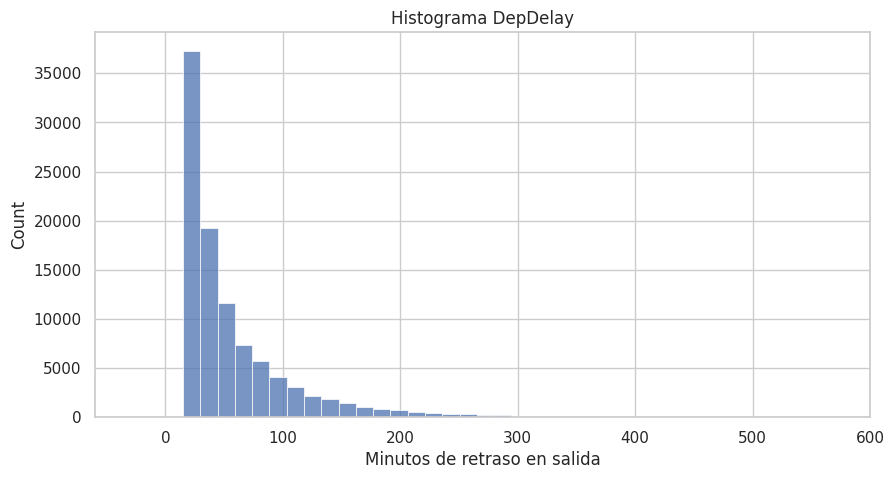

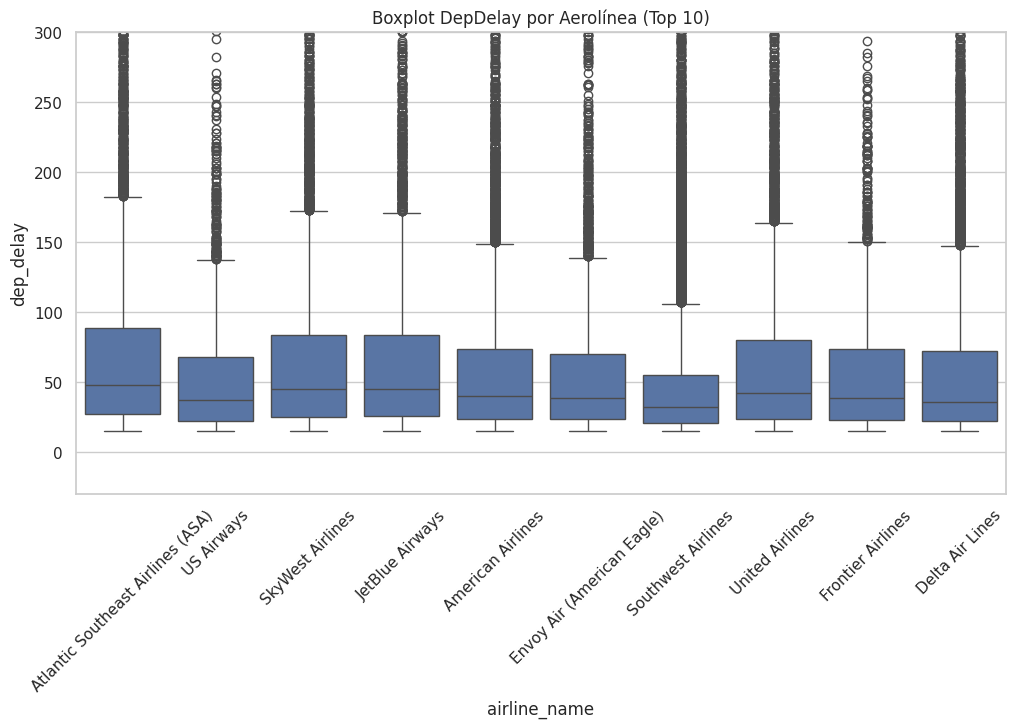

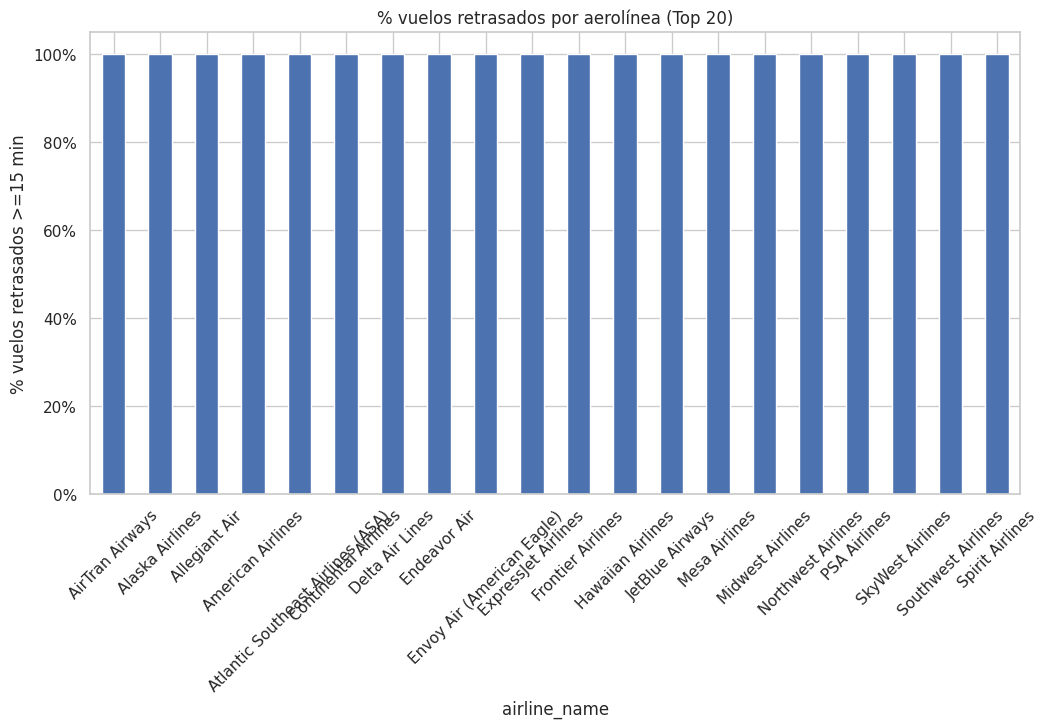

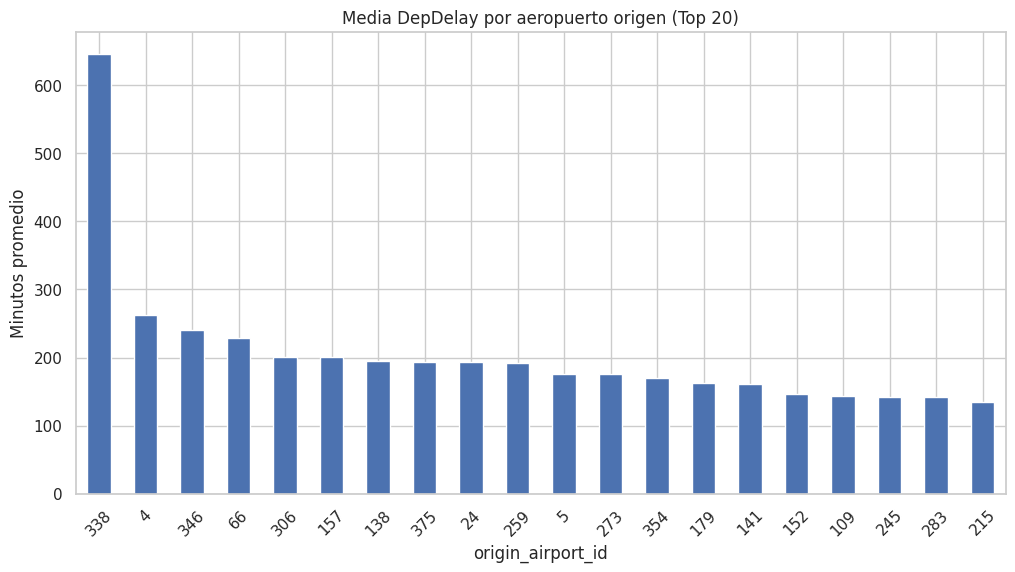

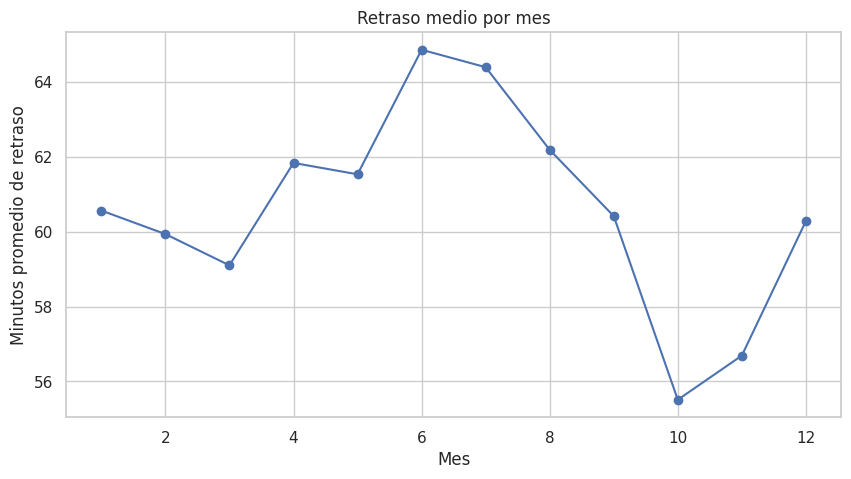

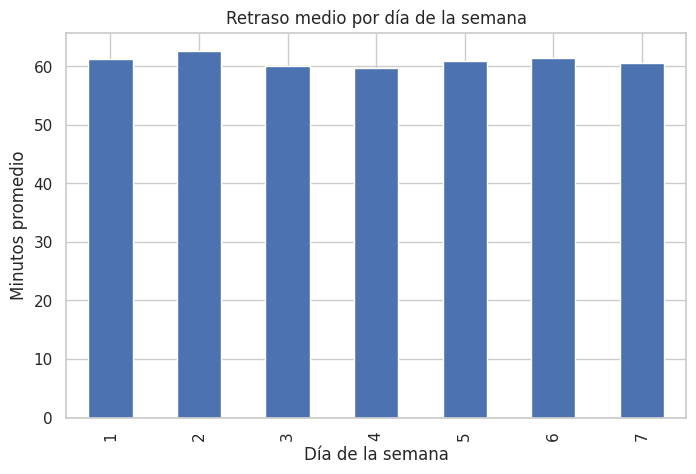

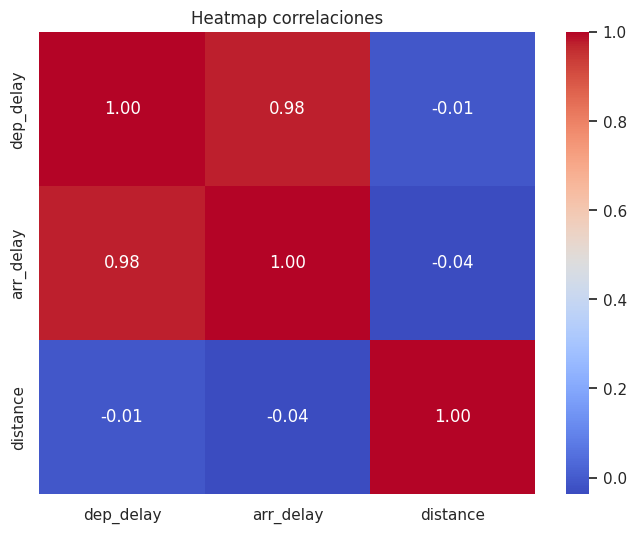

In [31]:
# Histograma DepDelay
if dep_col:
    plt.figure(figsize=(10,5))
    sns.histplot(fact[dep_col].dropna(), bins=100, kde=False)
    plt.xlim(-60, 600)
    plt.title("Histograma DepDelay")
    plt.xlabel("Minutos de retraso en salida")
    plt.show()

# Boxplot DepDelay por aerolínea top 10
if "airline_name" in fact.columns and dep_col:
    top10 = fact["airline_name"].value_counts().nlargest(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(data=fact[fact["airline_name"].isin(top10)], x="airline_name", y=dep_col)
    plt.xticks(rotation=45)
    plt.ylim(-30, 300)
    plt.title("Boxplot DepDelay por Aerolínea (Top 10)")
    plt.show()

# Barras % vuelos retrasados por aerolínea
if "airline_name" in fact.columns and "DepDel15" in fact.columns:
    pct_by_air = fact.groupby("airline_name")["DepDel15"].mean().sort_values(ascending=False) * 100
    plt.figure(figsize=(12,6))
    pct_by_air.head(20).plot(kind="bar")
    plt.ylabel("% vuelos retrasados >=15 min")
    plt.title("% vuelos retrasados por aerolínea (Top 20)")
    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

# Barras aeropuertos con más retrasos (media)
if "origin_code" in fact.columns and dep_col:
    try:
        top_orig_mean = agg_orig.sort_values("mean_dep", ascending=False).head(20)
        plt.figure(figsize=(12,6))
        top_orig_mean["mean_dep"].plot(kind="bar")
        plt.title("Media DepDelay por aeropuerto origen (Top 20)")
        plt.ylabel("Minutos promedio")
        plt.xticks(rotation=45)
        plt.show()
    except Exception as e:
        print('No se pudo graficar top_orig_mean:', e)

# Series temporales: retraso por mes
if "month" in fact.columns and dep_col:
    monthly = fact.groupby("month")[dep_col].mean().sort_index()
    plt.figure(figsize=(10,5))
    monthly.plot(marker="o")
    plt.title("Retraso medio por mes")
    plt.xlabel("Mes")
    plt.ylabel("Minutos promedio de retraso")
    plt.grid(True)
    plt.show()

# Día de la semana
dow_col = next((c for c in ["DayOfWeek","weekday","day_of_week"] if c in fact.columns), None)
if dow_col and dep_col:
    # intentar ordenar días si es numérico
    try:
        dow = fact.groupby(dow_col)[dep_col].mean().reindex(sorted(fact[dow_col].unique()))
    except Exception:
        dow = fact.groupby(dow_col)[dep_col].mean()
    plt.figure(figsize=(8,5))
    dow.plot(kind="bar")
    plt.title("Retraso medio por día de la semana")
    plt.xlabel("Día de la semana")
    plt.ylabel("Minutos promedio")
    plt.show()

# Heatmap correlaciones
corr_cols = [c for c in [dep_col, arr_col, dist_col, "TaxiOut","CarrierDelay","WeatherDelay","LateAircraftDelay"] if c in fact.columns]
if len(corr_cols) >= 2:
    corr = fact[corr_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Heatmap correlaciones")
    plt.show()


# Resumen de calidad de dato



In [41]:
# Resumen de calidad de dato

# 1. Valores faltantes
missing = fact.isnull().sum().sort_values(ascending=False)
print("Valores faltantes por columna:\n", missing)

# 2. Tipos de datos
print("\nTipos de datos y no-nulos:")
fact.info()

# 3. Duplicados
print("\nDuplicados en fact:", fact.duplicated().sum())

# 4. Outliers en dep_delay y arr_delay
print("\nDepDelay > 360 min:", (fact['dep_delay'] > 360).sum())
print("ArrDelay > 360 min:", (fact['arr_delay'] > 360).sum())

# 5. Distancia cero
if 'distance' in fact.columns:
    print("Distance == 0:", (fact['distance'] == 0).sum())

Valores faltantes por columna:
 origin_code               100000
origin_name               100000
dest_name                 100000
dest_code                 100000
dest_state                100000
dest_city                 100000
origin_state              100000
origin_city               100000
total_delay                  606
arr_delay                    606
airline_id                     0
fact_id                        0
flight_status                  0
distance                       0
dep_delay                      0
fecha_id                       0
origin_airport_id              0
destination_airport_id         0
carrier_code                   0
airline_name                   0
carrier_code_y                 0
airline_name_y                 0
airline_name_x                 0
carrier_code_x                 0
fecha                          0
year                           0
month                          0
day                            0
quarter                        0
weekday    


### Resumen de calidad de dato

**Hallazgos principales**  
- **Columnas de aeropuerto faltantes:** `origin_code`, `origin_name`, `origin_city`, `origin_state`, `dest_code`, `dest_name`, `dest_city`, `dest_state` están **completamente vacías (100 000 filas)**.  
- **Retrasos de llegada y total con nulos:** `arr_delay` y `total_delay` tienen **606** valores nulos.  
- **Indicadores de retraso:** `DepDel15`, `DepDel30`, `DepDel60` existen y no tienen nulos; **DepDel15 no discrimina** porque el mínimo de `dep_delay` es 15.  
- **Outliers significativos:** **722** vuelos con `dep_delay > 360 min` y **711** con `arr_delay > 360 min`.  
- **Integridad de claves y duplicados:** no hay duplicados (`0`) y las claves (`airline_id`, `origin_airport_id`, `destination_airport_id`, `fecha_id`) están completas.  
- **Distance:** no hay distancias cero (`Distance == 0: 0`).

**Impacto en el análisis**  
- Sin los nombres/códigos de aeropuertos no es posible presentar resultados legibles por aeropuerto ni mapas; esto limita visualizaciones y reportes por ubicación.  
- Las medias están sesgadas por outliers extremos; las métricas basadas en mediana e IQR serán más robustas.  
- `DepDel15` no es útil en este dataset; usar umbrales mayores (30/60 min) para medir frecuencia.

**Acciones recomendadas (priorizadas)**  
1. **Rellenar datos de aeropuerto**: mapear `origin_airport_id` y `destination_airport_id` a `dim_airport` para recuperar `airport_code` y `airport_name` y reemplazar las columnas vacías.  
2. **Revisar nulos en arr_delay/total_delay**: inspeccionar `flight_status` para las 606 filas nulas y decidir imputación o exclusión según caso (cancelled/diverted vs error ETL).  
3. **Investigar outliers > 360 min**: extraer top outliers, revisar causas (`flight_status`, demoras por causa operativa o meteorológica) y documentar si deben excluirse de estadísticas agregadas.  
4. **Usar métricas robustas**: reportar **mediana** y **percentiles** por aerolínea/aeropuerto; usar `DepDel30` y `DepDel60` para frecuencia informativa.  
5. **Documentar transformaciones**: anotar en el diccionario las imputaciones, umbrales usados y criterios de exclusión.

**KPIs sugeridos para reportes de calidad y operación**  
- **% vuelos ≥ 30 min** (`pct_del30`) y **% vuelos ≥ 60 min** (`pct_del60`) por aerolínea y aeropuerto.  
- **Mediana dep_delay** por aerolínea y por aerolínea×origen.  
- **Número de outliers > 360 min** por aerolínea.  
- **% filas con arr_delay nulo** y su relación con `flight_status`.




  
Se detectaron 606 nulos en `arr_delay/total_delay` y ~720 outliers en retrasos > 6 horas; las medias están afectadas por estos extremos.  
Se crearán y reportarán `DepDel30` y `DepDel60`; se priorizará el uso de medianas e IQR y se extraerán outliers para investigación operativa.


# Gráficas exploratorias

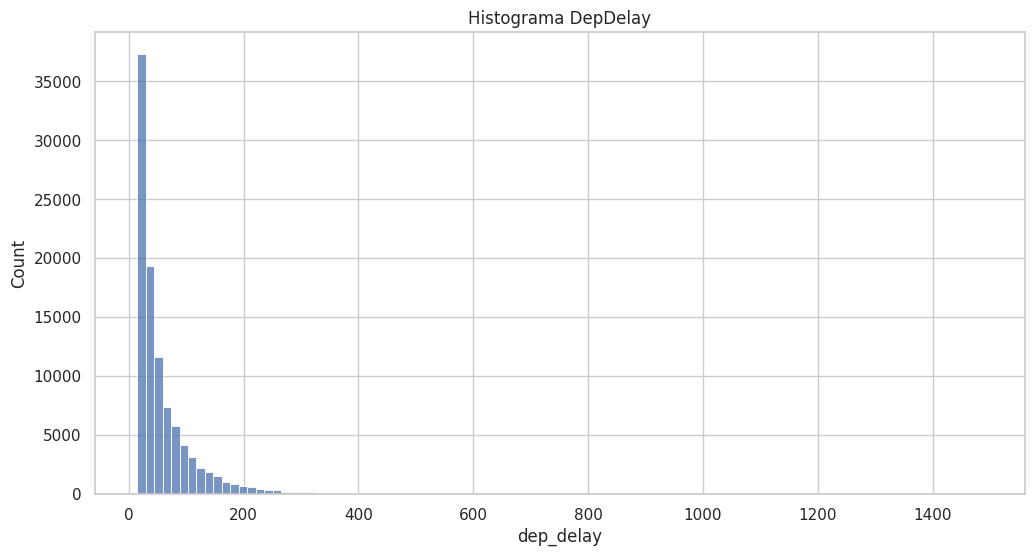

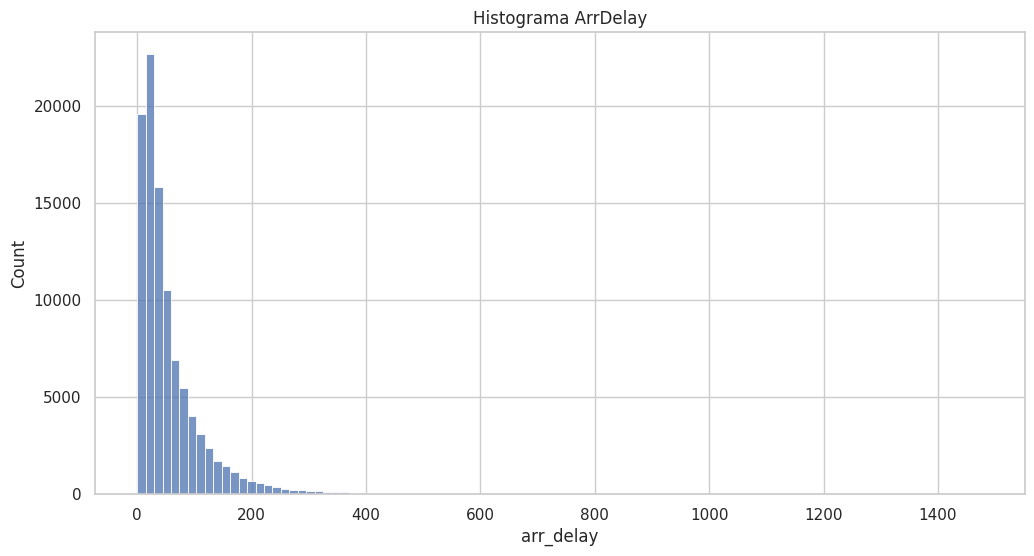

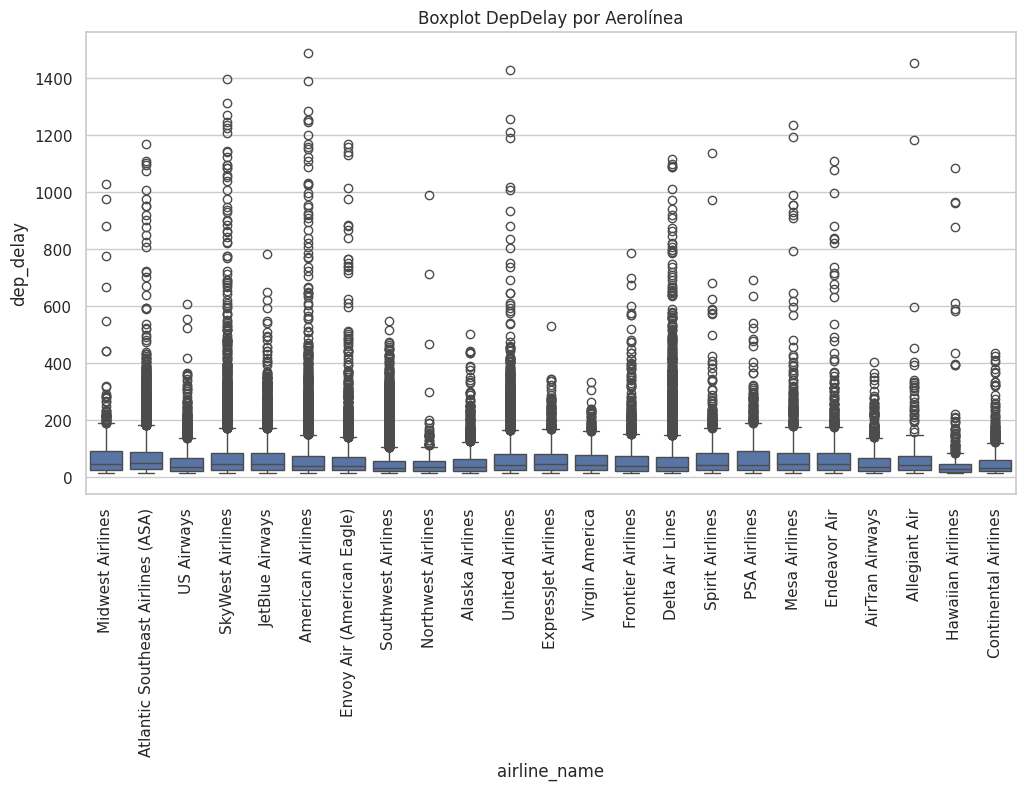

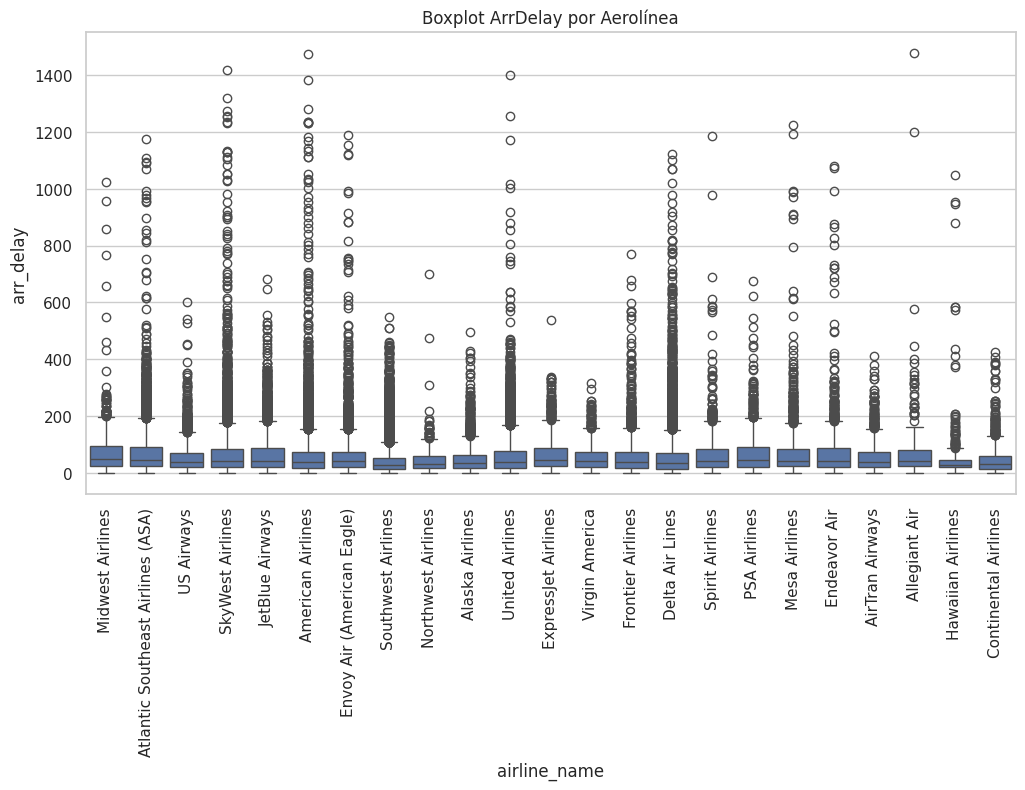

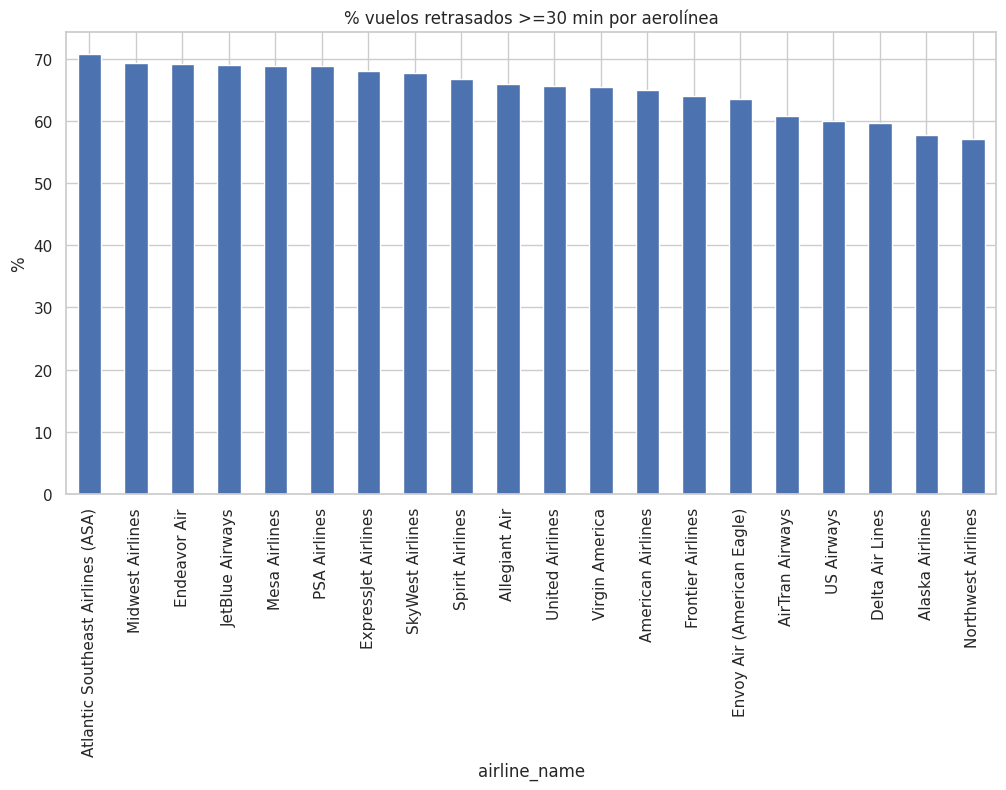

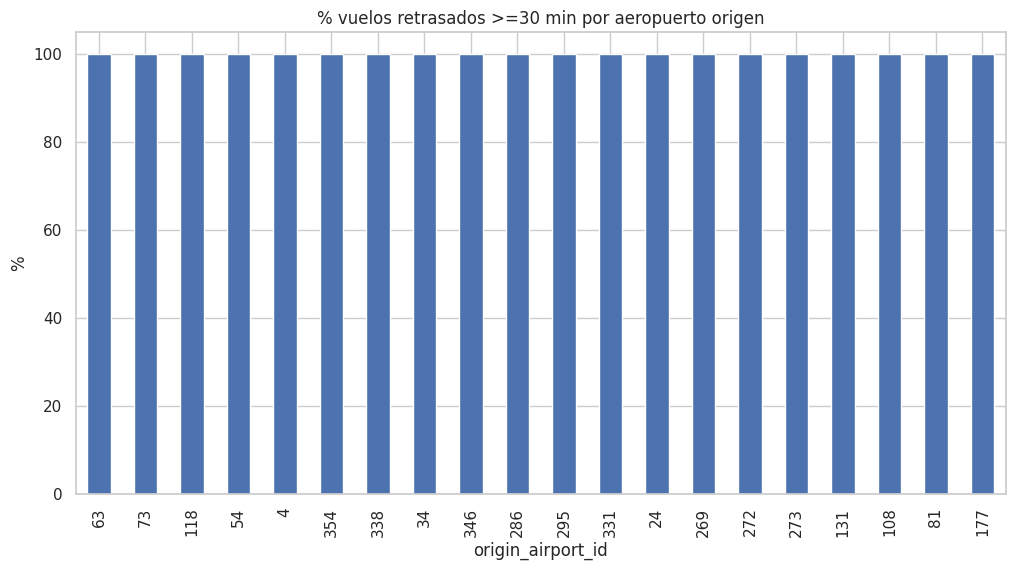

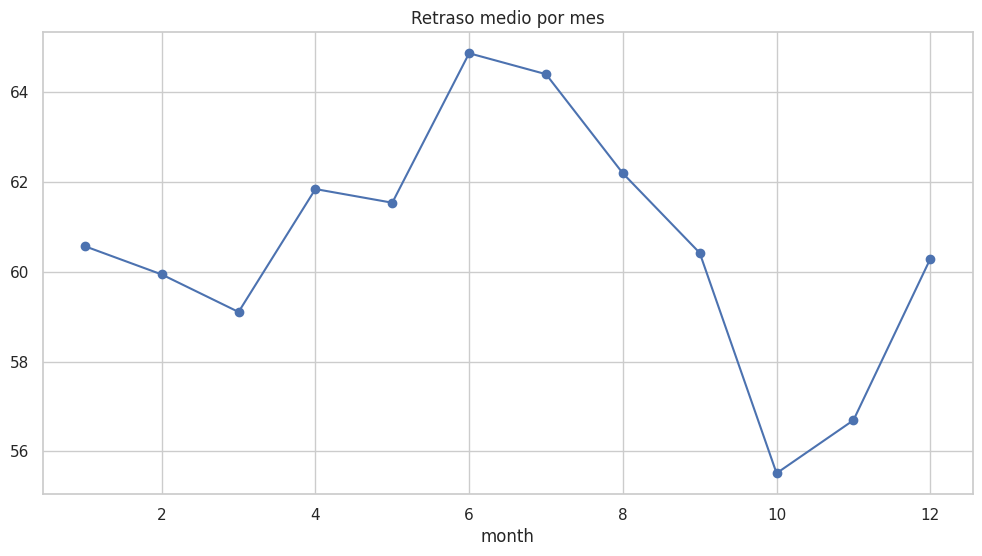

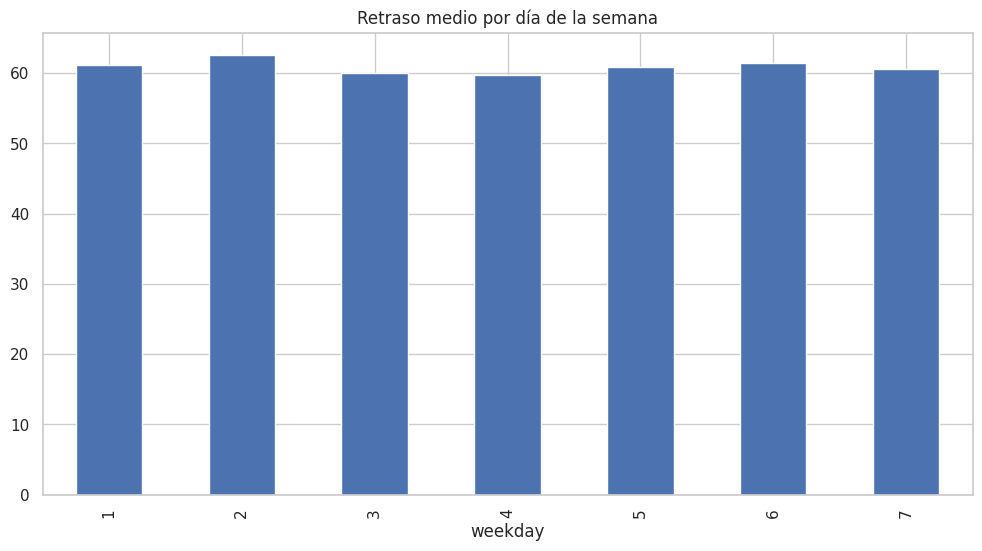

Columnas usadas para correlación: ['dep_delay', 'arr_delay', 'distance']


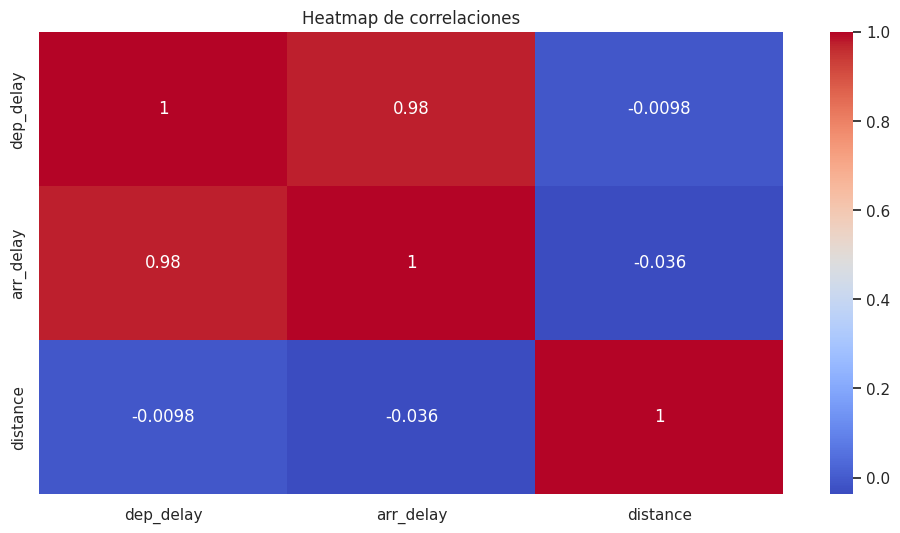

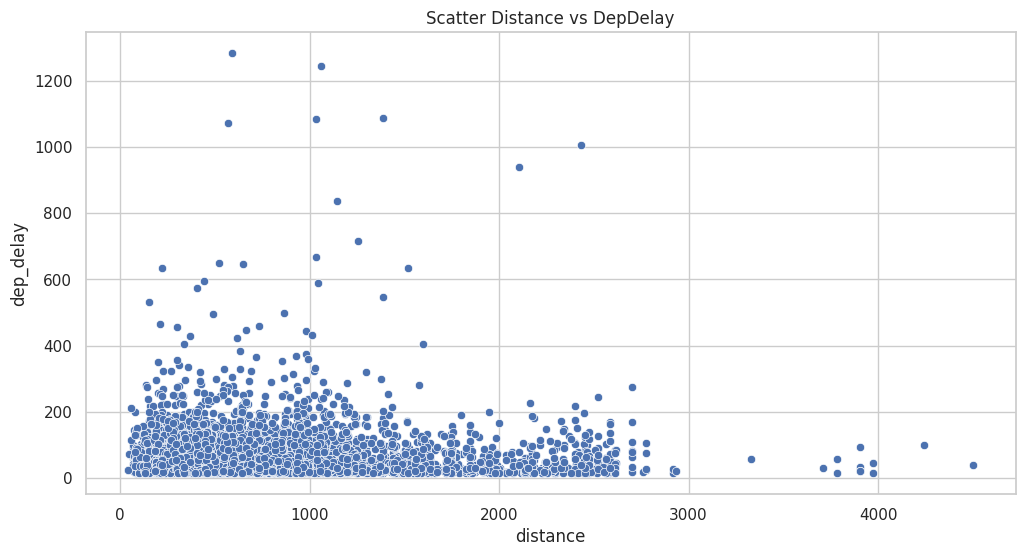

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Histograma dep_delay
sns.histplot(fact['dep_delay'], bins=100, kde=False)
plt.title("Histograma DepDelay")
plt.show()

# 2. Histograma arr_delay
sns.histplot(fact['arr_delay'], bins=100, kde=False)
plt.title("Histograma ArrDelay")
plt.show()

# 3. Boxplot dep_delay por aerolínea
sns.boxplot(x="airline_name", y="dep_delay", data=fact)
plt.xticks(rotation=90)
plt.title("Boxplot DepDelay por Aerolínea")
plt.show()

# 4. Boxplot arr_delay por aerolínea
sns.boxplot(x="airline_name", y="arr_delay", data=fact)
plt.xticks(rotation=90)
plt.title("Boxplot ArrDelay por Aerolínea")
plt.show()

# 5. Barras: % retrasos >=30 min por aerolínea
fact["DepDel30"] = (fact["dep_delay"] >= 30).astype(int)
pct_air = fact.groupby("airline_name")["DepDel30"].mean() * 100
pct_air.sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("% vuelos retrasados >=30 min por aerolínea")
plt.ylabel("%")
plt.show()

# 6. Barras: % retrasos >=30 min por aeropuerto origen
pct_orig = fact.groupby("origin_airport_id")["DepDel30"].mean() * 100
pct_orig.sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("% vuelos retrasados >=30 min por aeropuerto origen")
plt.ylabel("%")
plt.show()

# 7. Serie temporal: retraso medio por mes
fact.groupby("month")["dep_delay"].mean().plot(marker="o")
plt.title("Retraso medio por mes")
plt.show()

# 8. Serie temporal: retraso medio por día de la semana
fact.groupby("weekday")["dep_delay"].mean().plot(kind="bar")
plt.title("Retraso medio por día de la semana")
plt.show()

# 9. Heatmap de correlaciones (robusto)

# Lista de columnas que nos interesan
candidate_cols = ["dep_delay","arr_delay","distance",
                  "CarrierDelay","WeatherDelay","LateAircraftDelay"]

# Filtrar solo las que existen en fact
corr_cols = [c for c in candidate_cols if c in fact.columns]

print("Columnas usadas para correlación:", corr_cols)

# Calcular correlación si hay al menos 2 columnas
if len(corr_cols) >= 2:
    corr = fact[corr_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Heatmap de correlaciones")
    plt.show()
else:
    print("No hay suficientes columnas numéricas para calcular correlaciones.")

# 10. Scatterplot distance vs dep_delay
sns.scatterplot(x="distance", y="dep_delay", data=fact.sample(5000))
plt.title("Scatter Distance vs DepDelay")
plt.show()

# Mapa conceptual del dataset



#### Visión general
Este mapa conceptual muestra cómo se relaciona la **tabla de hechos** `fact_flights_sample` con las **dimensiones** `dim_airline`, `dim_airport` y `dim_date`, qué llaves se usan y qué atributos clave aporta cada entidad. Pega el diagrama ASCII o el código de `networkx` en tu notebook o dibújalo en draw.io/diagrams.net.

---

#### Entidades y atributos clave

| **Entidad** | **Clave primaria** | **FK en fact** | **Atributos relevantes** |
|---|---:|---|---|
| **fact_flights_sample** | `fact_id` | `airline_id`, `origin_airport_id`, `destination_airport_id`, `fecha_id` | `dep_delay`, `arr_delay`, `total_delay`, `distance`, `flight_status`, `DepDel30`, `DepDel60` |
| **dim_airline** | `airline_id` | — | `carrier_code`, `airline_name` |
| **dim_airport** | `airport_id` | — | `airport_code`, `airport_name`, `city`, `state` |
| **dim_date** | `fecha_id` | — | `fecha`, `year`, `month`, `day`, `weekday`, `is_holiday` |

---

#### Relaciones y cardinalidad
- **fact_flights_sample → dim_airline** : *many-to-one* por `airline_id` (muchos vuelos por aerolínea).  
- **fact_flights_sample → dim_airport** : *many-to-one* por `origin_airport_id` y por `destination_airport_id` (muchos vuelos por aeropuerto).  
- **fact_flights_sample → dim_date** : *many-to-one* por `fecha_id` (muchos vuelos por fecha).  

---

## Mapa conceptual del dataset

**Descripción:** `fact_flights_sample` es la tabla de hechos que registra cada vuelo y sus métricas operativas. Se relaciona con:
- `dim_airline` mediante `airline_id` para obtener `airline_name` y `carrier_code`.
- `dim_airport` mediante `origin_airport_id` y `destination_airport_id` para obtener códigos y nombres de aeropuertos.
- `dim_date` mediante `fecha_id` para atributos temporales (mes, día, feriado).

**Cardinalidad:** cada vuelo (fact) apunta a una sola aerolínea, un solo origen, un solo destino y una sola fecha; cada dimensión puede agrupar muchos vuelos.


---

#### Leyenda y notas para el entregable
- **PK** = Primary Key; **FK** = Foreign Key.  
- Indica en el mapa si una FK está vacía en el dataset (por ejemplo `origin_code` vacío) y anota la acción: *rellenar desde `dim_airport`*.  
- Añade una versión final del mapa como imagen en la sección **Data Understanding** de tu notebook.

---



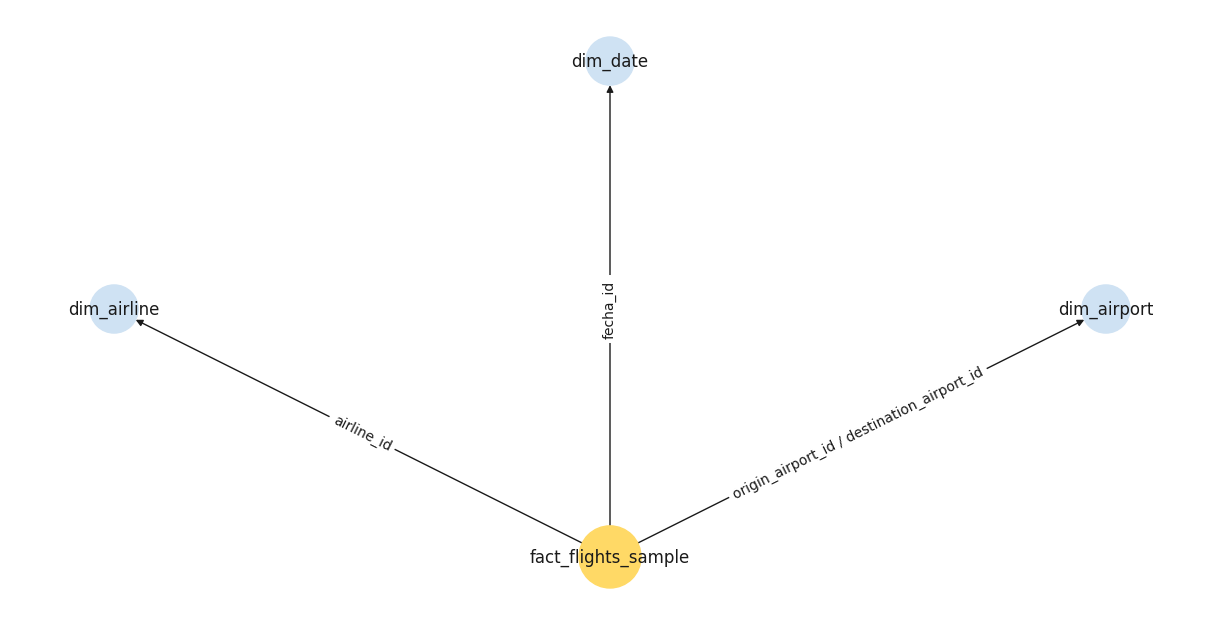

In [39]:


#### diagrama visual
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node("fact_flights_sample", size=2000)
G.add_node("dim_airline", size=1200)
G.add_node("dim_airport", size=1200)
G.add_node("dim_date", size=1200)

G.add_edge("fact_flights_sample", "dim_airline", label="airline_id")
G.add_edge("fact_flights_sample", "dim_airport", label="origin_airport_id / destination_airport_id")
G.add_edge("fact_flights_sample", "dim_date", label="fecha_id")

pos = {
    "fact_flights_sample": (0,0),
    "dim_airline": (-1,1),
    "dim_airport": (1,1),
    "dim_date": (0,2)
}
nx.draw(G, pos, with_labels=True, node_size=[2000,1200,1200,1200], node_color=["#ffd966","#cfe2f3","#cfe2f3","#cfe2f3"])
edge_labels = nx.get_edge_attributes(G,'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis('off')
plt.show()
